
#### Packages einlesen

In [1]:
import netCDF4 as nc 
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import xarray as xr
import PIL 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd



#### Filepaths hinterlegen

In [2]:
##### Filepath Observation #####
filepath_observation_files = '/work/ch0636/g300123/Calibration_data/observation_ncfiles'
selected_observation = 'GRDC-Daily'
#selected_observation = 'GRDC-Daily-Spain'

##### Filepath Simulation #####
filepath_simulation_results = '/work/ch0636/g300123/Outputs_5arcmin'
# selected_simulation = '24_02_24_landcover_5arcmin_0000_zeros'
# selected_simulation = '24_03_20_init_INPTAG_2003_LAT_0000_zeros
selected_simulation = '24_03_23_init_INPTAG_1999to2010_LAT_0000_zeros_forvalidation'


##### Outputfile path for Maps #####
file_save_graph_automatically = '/work/ch0636/g300123/Calibration'  + '/' + 'automatically' + '/' + 'maps_individualRasterOfStations_automatically'


##### Outputfile path for xlsx-data-files #####
# file_save_xlsx = '/work/ch0636/g300123/Calibration'  + '/' + 'xlsx_dailydischargeStations_CWatM'




#### Festlegen, welches Jahr untersucht werden sollen [Genau ein Jahr auswählen z.B. vom 01-01-2003 bis 31-12-2003]


In [3]:
start_date_obs = '2003-01-01' 
end_date_obs = '2003-12-31' 
start_date_sim = '01-01-2003' 
end_date_sim = '12-31-2003' 
year = 2003


## Oberservation nc-Datensätze

### Oberservation nc-Datensätze von GRDC einlesen

In [4]:
# nc-file in xarray einlesen
observation_file = '/work/ch0636/g300128/data/GRDC-Daily-allEurope3 - Kopie.nc'
xr_obs = xr.open_dataset(observation_file)
xr_obs

# Liste aller einzigartigen IDs
list_of_station_IDs = xr_obs['id'].values


# Dictionary über die Stationsnamen 
Dict_stationname = {}
for ID in list_of_station_IDs:
    stationname = xr_obs['station_name'].sel(id = ID).values
    country = xr_obs['country'].sel(id = ID).values
    Dict_stationname[ID] = f"{stationname} ({country})"



## Simulation nc-Datensätze

### Simulation nc-Datensätze von CWatM einlesen 

In [5]:
# nc-file in xarray einlesen
simulation_file = filepath_simulation_results  + '/' + selected_simulation  + '/' + 'discharge_daily.nc'
xr_sim = xr.open_dataset(simulation_file)
xr_sim 

### Variablen zuweisen Latitude, longitude and time 
longitudes_sim = xr_sim['lon'].values
latitudes_sim = xr_sim['lat'].values
time_sim = xr_sim['time'].sel(time = slice (start_date_sim, end_date_sim)).values

# Abstand zwischen den Gitterlinien
step_lat = np.abs(latitudes_sim[1] - latitudes_sim[0])
step_lon = np.abs(longitudes_sim[1] - longitudes_sim[0])

# Variabel zuweisen discharge
xr_sim_data_everywhere = xr_sim['discharge'].sel(time = slice (start_date_sim, end_date_sim))
sim_data_everywhere = xr_sim['discharge'].sel(time = slice (start_date_sim, end_date_sim)).values
    

## Datensätze über jährliche Summen erstellen

#### Definitionen um jährliche Summen zu berechnen 

In [6]:

# Definition um Summe über das ganze Jahr zu berechnen 
def calculate_yearly_sum(xr_data):
    selected_data = xr_data.sel(time = slice(start_date_sim, end_date_sim))
    yearly_sum = selected_data.sum(dim ='time')
    yearly_sum = yearly_sum.expand_dims(dim ='time')
    return yearly_sum

# Dimensionen überprüfen 
def control_dimensions(data_set):
    time_dim = np.shape(data_set)[0]
    lat_dim = np.shape(data_set)[1]
    lon_dim = np.shape(data_set)[2]
    return print('dimension of time = ' , time_dim , ', dimension of lattitudes = ' , lat_dim  , ', dimension of longitudes = ' , lon_dim)



#### Jährliche Summen berechnen für unsere Variablen 

In [7]:
# Für unsere Variablen ausführen
xr_yearly_sum_discharge  = calculate_yearly_sum(xr_sim_data_everywhere)
# xr-Arrays auslesen und in numpy-arrays umwandeln
yearly_sum_discharge = xr_yearly_sum_discharge.values

# Für unsere Variablen ausführen
control_dimensions(yearly_sum_discharge)


dimension of time =  1 , dimension of lattitudes =  437 , dimension of longitudes =  625


## Koordinaten der Stationen auslesen

#### lat_station_index und lon_station_index automatisch herausfinden 

In [21]:
# Geographische Koordinaten automatisch auslesen 
lon_station = {}
lat_station = {}
height_station = {}

for ID in list_of_station_IDs: 
    lon_station [ID] = xr_obs['geo_x'].sel(id = ID).values
    lat_station[ID] = xr_obs['geo_y'].sel(id = ID).values
    height_station [ID] =  xr_obs['geo_z'].sel(id = ID).values
    
# Alle Werte der latitudes und longitudes auslesen 
latitudes = xr_sim['lat'].values
longitudes = xr_sim['lon'].values

# Nächstgelegende Lat und lon index automatisch auslesen
lat_station_index = {}
lon_station_index = {}
lat_gauged_station = {}
lon_gauged_station = {}

for ID in list_of_station_IDs: 
    lat_station_index [ID] = np.abs(latitudes - lat_station[ID]).argmin()
    lon_station_index [ID] = np.abs(longitudes - lon_station[ID]).argmin()

    
# Informationen über Stationen ausgeben lassen
# for ID in list_of_station_IDs:
#    print(Dict_stationname[ID],':  ', 'lat & lon:', np.round(lat_station[ID],5) ,  '&' , np.round(lon_station[ID],5))
#    print(Dict_stationname[ID],':  ', 'lat index & lon index:', lat_station_index[ID] , '&' , lon_station_index [ID])
#    print('----------------------------------------------------------')

#### Lat-Index und Long-Index um die Stationen drum herum berechnen 

In [9]:
# Indizes der Station um die ausgewählte Station drum herum berechnen 
# 24 Stationen in nächster Nähe von dem berechneten Standort 
# 16 Stationen + 8 Stationen + 1 Station in der Mitte
lat_station_index_min = {}
lon_station_index_min = {}
lat_station_index_max = {}
lon_station_index_max = {}
for ID in list_of_station_IDs:
    lat_station_index_min [ID] = lat_station_index [ID] -2
    lat_station_index_max [ID] = lat_station_index [ID] +2
    lon_station_index_min [ID] = lon_station_index [ID] -2
    lon_station_index_max [ID] = lon_station_index [ID] +2

# Echte Koordinaten der Raster um die Station drum herum
lat_station_min = {}
lon_station_min = {}
lat_station_max = {}
lon_station_max = {}
for ID in list_of_station_IDs:
    lat_station_min [ID] = latitudes[lat_station_index_min [ID]]
    lat_station_max [ID] = latitudes[lat_station_index_max [ID]] 
    lon_station_min [ID] = longitudes[lon_station_index_min [ID]]
    lon_station_max [ID] = longitudes[lon_station_index_max [ID]]

# latitude und longitude Werte für die Grenze der Abbildungen festlegen 
A_lat = {}
A_lon = {}
B_lat = {}
B_lon = {}
for ID in list_of_station_IDs:
    A_lat [ID] = min(lat_station_min [ID], lat_station_max [ID])
    A_lon [ID] = min(lon_station_min [ID], lon_station_max [ID])
    B_lat [ID] = max(lat_station_min [ID], lat_station_max [ID])
    B_lon [ID] = max(lon_station_min [ID], lon_station_max [ID])

# Stationen drum herum
# for ID in list_of_station_IDs:
#    print(Dict_stationname[ID] ,':  ', 'lat index min & lon index min:', lat_station_index_min [ID] , '&' , lon_station_index_min [ID] , '  ,  ' ,  'lat min & lon min:', np.round(A_lat [ID] , 4) , '&' , np.round(A_lon [ID] , 4) )
#    print(Dict_stationname[ID] ,':  ',   'lat index max & lon index max:', lat_station_index_max [ID], '&' , lon_station_index_max [ID] , '  ,  ' , 'lat max & lon max:', np.round(B_lat [ID] ,4) , '&' , np.round(B_lon [ID] ,4) )



## Abbildungen erstellen

#### Farben für Karten in Cartopy

In [10]:
# Find a nice color for all the maps

# Erstellen der benutzerdefinierten Colormap
def custom_cmap():
    colors = [(0, 'white'), (1, 'blue')]
    cmap_name = 'custom_cmap'
    cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
    return cmap
new_color = custom_cmap()

#### Weitere Basisinformationen

In [11]:
# Basis informationen die für alle Karten gelten

# Mesh-Grid erstellen in Cartopy 
lon, lat = np.meshgrid(longitudes_sim, latitudes_sim)
x, y = lon, lat 


## Erste Karte erstellen mit jährlichen Summen rund um die Station

In [22]:
# Maximale und minimale Werte für z im Gesamten Zeitraum des einen Jahres herausfinden für die höchste Modifikation mit 100% 
z_min = {}
z_max = {}
for ID in list_of_station_IDs:
    z_id = np.squeeze(yearly_sum_discharge [ 0 , lat_station_index_min [ID] : lat_station_index_max [ID] + 1  , lon_station_index_min [ID] : lon_station_index_max [ID] +1 ])
    z_min [ID] = np.min(z_id)
    z_max [ID] = np.max(z_id)


# Discharge maps in Cartopy
for ID in list_of_station_IDs:
    z = np.squeeze(yearly_sum_discharge[0,:,:])
    choosen_projection = ccrs.PlateCarree()   
    ax = plt.axes(projection = choosen_projection) 
    ax.set_extent([A_lon [ID], B_lon [ID], A_lat [ID], B_lat [ID]], crs = choosen_projection)
    z_color = ax.pcolormesh(x, y, z , cmap = new_color , vmin = z_min[ID], vmax = z_max[ID])
    color_bar = plt.colorbar(z_color, ax=ax, orientation='vertical', pad = 0.2 , shrink = 0.8)
    ax.coastlines(linewidth=0.1, linestyle='-')
    # Punkt für Station hinzufügen
    ax.plot(lon_station [ID], lat_station [ID], 'ro', markersize=10, transform=ccrs.PlateCarree())
    plt.title('Yearly-sum of discharge [m$^3$/s] around station \n' + str(ID) + ' / ' + Dict_stationname[ID] ) 
    xlocs = np.arange(A_lon [ID] - 0.5 * step_lon , B_lon [ID], step_lon)
    ylocs = np.arange(A_lat [ID] - 0.5 * step_lat,  B_lat [ID], step_lat)
    ax.gridlines(xlocs=xlocs, ylocs=ylocs, draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
#    plt.show()
    plt.close()


## Welche Indixes sind für die verschiedenen Stationen passend

#### Ursprüngliche Indices einlesen, um die anschließend anpassen zu können

In [13]:
lat_station_index_fit = {} 
lon_station_index_fit = {}
for ID in list_of_station_IDs:
    lat_station_index_fit [ID] = lat_station_index [ID]
    lon_station_index_fit [ID] = lon_station_index [ID]


#### Festlegen, für welche Stationen es Abweichungen bei der Wahl des passenden Rasters im Vergleich zur automatischen Auswahl gibt

In [14]:
# Manuell hier die Stations_IDs eingeben für die Veränderungen forgenommen werden müssen 
list_of_station_IDs_lat_minus1 = [ 6221102 , 6139770 , 6233650 , 6226300 , 6781800 , 6226310 , 6227130 , 6227410 ]
list_of_station_IDs_lon_minus1 = [ 6212740 ]
list_of_station_IDs_lat_plus1 = []
list_of_station_IDs_lon_plus1 = [ 6216610 ]

# Chooz (Belgium) / 6221102 lat -1 
# Neublans-Abergement (France) / 6139770 lat -1
# Sollefta (Sweden) / 6233650 lat -1 
# Castejon (Spain) / 6226300 lat -1 
# Tighina (Moldavia) / 6781800 lat -1 

# 6212740  /  VALLADOLID-PISUERGA (ES) :  lon -1 
# 6216610  /  VILLANUEVA DE LA SERENA (ES) :   lon +1 
# s.o. 6226300  /  CASTEJON (ES) :   lat -1 
# 6226310  /  CAPARROSO (ES) :   lat -1
# 6227130  /  LA PRESA (ES) :   lat -1
# 6227410  /  ROJALES (ES) :   lat -1


    

#### Indices anpassen

In [87]:
# Jetzt Dictionarys für lat_index_fit und lon_index_fit damit erstellen 
lat_station_index_fit = {}
lon_station_index_fit = {}

for ID in list_of_station_IDs:
    lat_station_index_fit[ID] = lat_station_index[ID]
    lon_station_index_fit[ID] = lon_station_index[ID]
    
for ID in list_of_station_IDs_lat_minus1:
    if ID in list_of_station_IDs:
        lat_station_index_fit[ID] = lat_station_index[ID] - 1 
for ID in list_of_station_IDs_lon_minus1:
    if ID in list_of_station_IDs:
        lon_station_index_fit[ID] = lon_station_index[ID] - 1
for ID in list_of_station_IDs_lat_plus1:
    if ID in list_of_station_IDs:
        lat_station_index_fit[ID] = lat_station_index[ID] + 1 
for ID in list_of_station_IDs_lon_plus1:
    if ID in list_of_station_IDs:
        lon_station_index_fit[ID] = lon_station_index[ID] + 1
lat_gauged_station = []
lon_gauged_station = []
for ID in list_of_station_IDs: 
    lat_gauged_station.append(round(lat_station[ID] - 5/60*(lat_station_index_fit[ID]-lat_station_index[ID]),4))
    lon_gauged_station.append(round(lon_station[ID] + 5/60*(lon_station_index_fit[ID]-lon_station_index[ID]),4))
# ID = list_of_station_IDs[0]
# lat_station[ID] - 5/60*(lat_station_index_fit[ID]-lat_station_index[ID])

In [89]:
lon_gauged_station

[-8.375,
 -7.633,
 0.5444,
 5.3501,
 16.9359,
 -5.4128,
 -3.608,
 -3.7994,
 -5.0778,
 -0.8811,
 23.3959,
 19.7036,
 12.0939,
 9.2246,
 9.125,
 11.9784,
 8.6857,
 14.6897,
 25.8915,
 5.72,
 22.703,
 17.4416,
 21.7461,
 21.12,
 -0.3077,
 10.2775,
 28.0162,
 24.2994,
 27.5122,
 29.4711,
 25.8879,
 7.6167]

In [119]:
lat_dict = {
    'data' : lat_gauged_station,
    'dims' : ['id'],  # 'dims' doit être une liste
    'coords' : {'id': {'dims': 'id', 'data': list_of_station_IDs}}  # 'coords' doit être un dictionnaire de dictionnaires
}
lon_dict = {
    'data' : lon_gauged_station,
    'dims' : ['id'],  # 'dims' doit être une liste
    'coords' : {'id': {'dims': 'id', 'data': list_of_station_IDs}}  # 'coords' doit être un dictionnaire de dictionnaires
}


lat_array = xr.DataArray.from_dict(lat_dict)
lon_array = xr.DataArray.from_dict(lon_dict)
lat_array.name = 'gauged_lat'
lon_array.name = 'gauged_lon'

xr_obs_gauged_station=xr.merge([xr_obs,lat_array,lon_array])
ds
xr_obs_gauged_station.to_netcdf('/work/ch0636/g300128/data/GRDC-Daily-allEurope_Gauged.nc')

-0.08334503784179503

## Graphen erstellen


--------------------------------------------------------------------------------------------------------
6232911  /  PAJALA PUMPHUS (SE) :   lat & lon: 67.2074 & 23.3959
6232911  /  PAJALA PUMPHUS (SE) :   lat index & lon index: 47 & 408
6232911  /  PAJALA PUMPHUS (SE) :   lat index fit & lon index fit: 47 & 408
6232911  /  PAJALA PUMPHUS (SE) :   lat index fit & lon index fit: 67.2074 & 23.3959


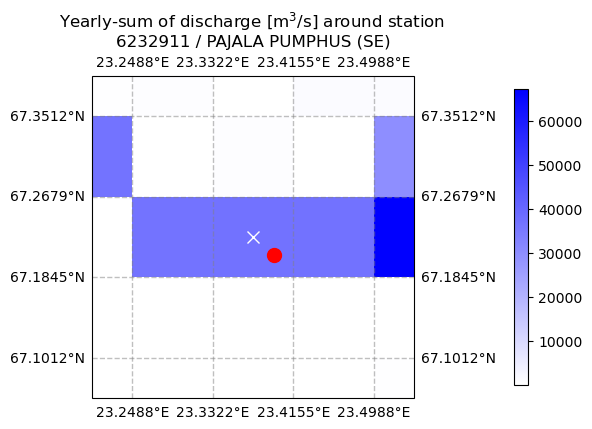

--------------------------------------------------------------------------------------------------------
6233510  /  GRANAKER (SE) :   lat & lon: 64.2233 & 19.7036
6233510  /  GRANAKER (SE) :   lat index & lon index: 83 & 364
6233510  /  GRANAKER (SE) :   lat index fit & lon index fit: 83 & 364
6233510  /  GRANAKER (SE) :   lat index fit & lon index fit: 64.2233 & 19.7036


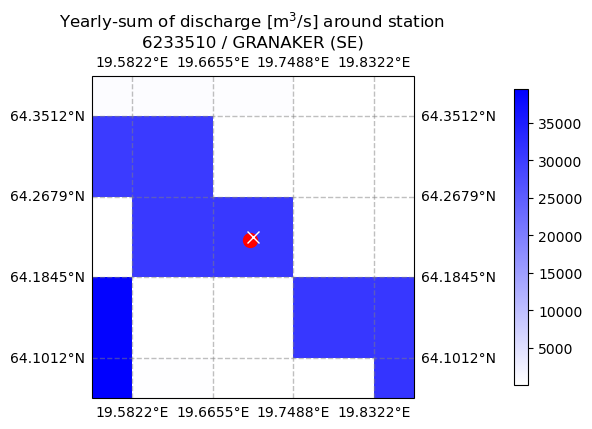

--------------------------------------------------------------------------------------------------------
6243050  /  KIRCHBICHL - BICHLWANG (AT) :   lat & lon: 47.52334 & 12.09389
6243050  /  KIRCHBICHL - BICHLWANG (AT) :   lat index & lon index: 283 & 273
6243050  /  KIRCHBICHL - BICHLWANG (AT) :   lat index fit & lon index fit: 283 & 273
6243050  /  KIRCHBICHL - BICHLWANG (AT) :   lat index fit & lon index fit: 47.5233 & 12.0939


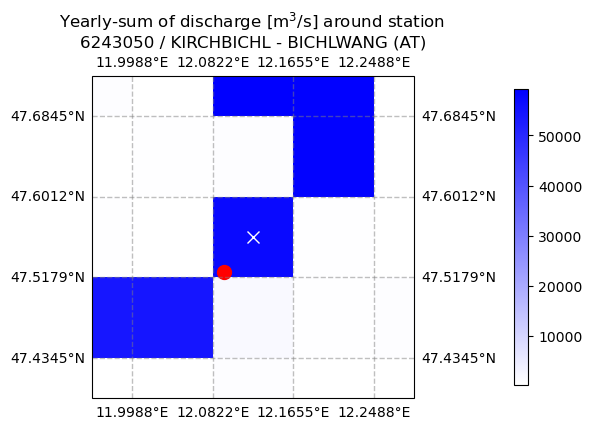

--------------------------------------------------------------------------------------------------------
6335240  /  KLEINHEUBACH (DE) :   lat & lon: 49.71648 & 9.22458
6335240  /  KLEINHEUBACH (DE) :   lat index & lon index: 257 & 238
6335240  /  KLEINHEUBACH (DE) :   lat index fit & lon index fit: 257 & 238
6335240  /  KLEINHEUBACH (DE) :   lat index fit & lon index fit: 49.7165 & 9.2246


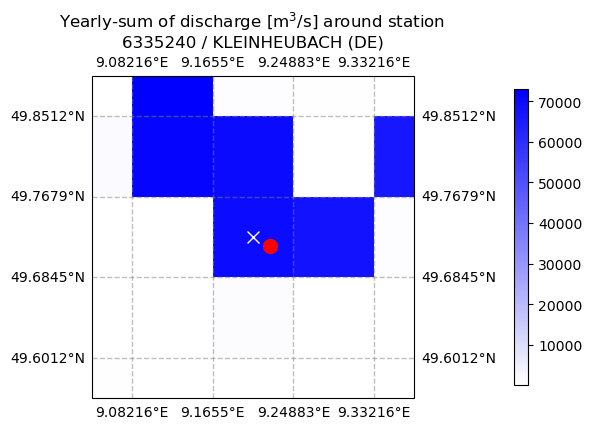

--------------------------------------------------------------------------------------------------------
6337200  /  INTSCHEDE (DE) :   lat & lon: 52.964 & 9.125
6337200  /  INTSCHEDE (DE) :   lat index & lon index: 218 & 237
6337200  /  INTSCHEDE (DE) :   lat index fit & lon index fit: 218 & 237
6337200  /  INTSCHEDE (DE) :   lat index fit & lon index fit: 52.964 & 9.125


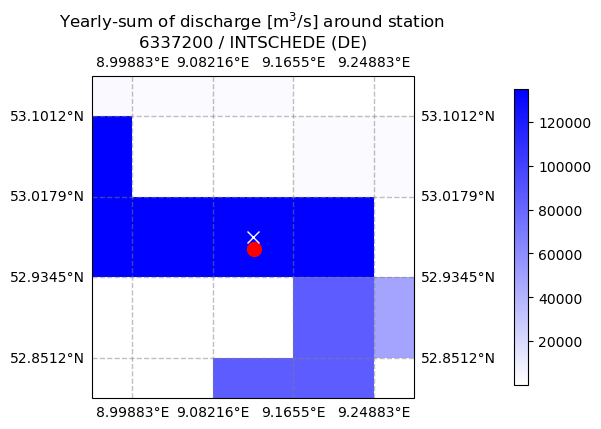

--------------------------------------------------------------------------------------------------------
6340160  /  TANGERMUENDE (DE) :   lat & lon: 52.5466 & 11.9784
6340160  /  TANGERMUENDE (DE) :   lat index & lon index: 223 & 271
6340160  /  TANGERMUENDE (DE) :   lat index fit & lon index fit: 223 & 271
6340160  /  TANGERMUENDE (DE) :   lat index fit & lon index fit: 52.5466 & 11.9784


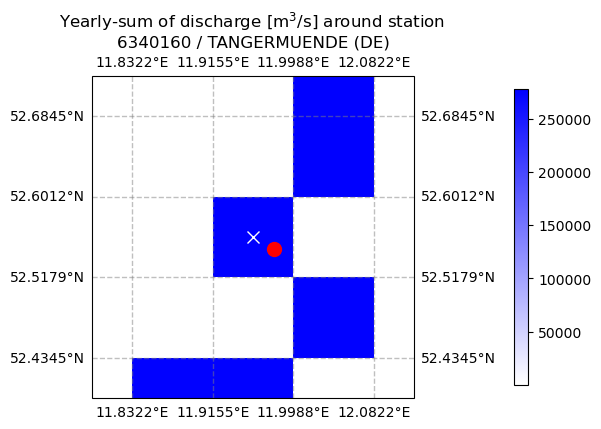

--------------------------------------------------------------------------------------------------------
6348200  /  MONTECASTELLO (IT) :   lat & lon: 44.9485 & 8.6857
6348200  /  MONTECASTELLO (IT) :   lat index & lon index: 314 & 232
6348200  /  MONTECASTELLO (IT) :   lat index fit & lon index fit: 314 & 232
6348200  /  MONTECASTELLO (IT) :   lat index fit & lon index fit: 44.9485 & 8.6857


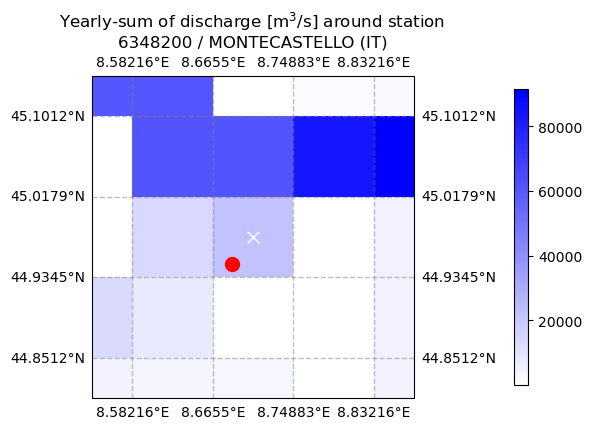

--------------------------------------------------------------------------------------------------------
6357500  /  EISENHUETTENSTADT (DE) :   lat & lon: 52.15361 & 14.68972
6357500  /  EISENHUETTENSTADT (DE) :   lat index & lon index: 228 & 304
6357500  /  EISENHUETTENSTADT (DE) :   lat index fit & lon index fit: 228 & 304
6357500  /  EISENHUETTENSTADT (DE) :   lat index fit & lon index fit: 52.1536 & 14.6897


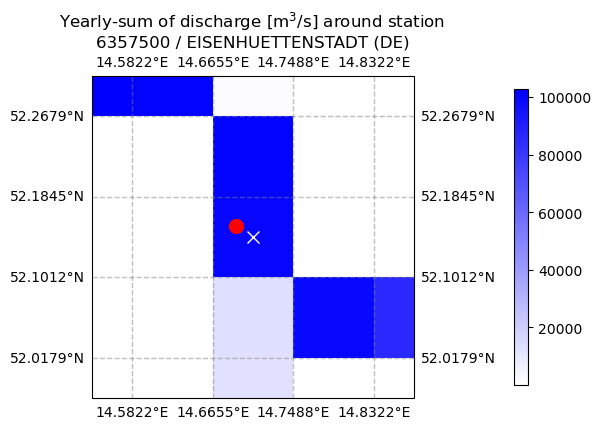

--------------------------------------------------------------------------------------------------------
6373304  /  JEKABPILS (LV) :   lat & lon: 56.4976 & 25.89148
6373304  /  JEKABPILS (LV) :   lat index & lon index: 176 & 438
6373304  /  JEKABPILS (LV) :   lat index fit & lon index fit: 176 & 438
6373304  /  JEKABPILS (LV) :   lat index fit & lon index fit: 56.4976 & 25.8915


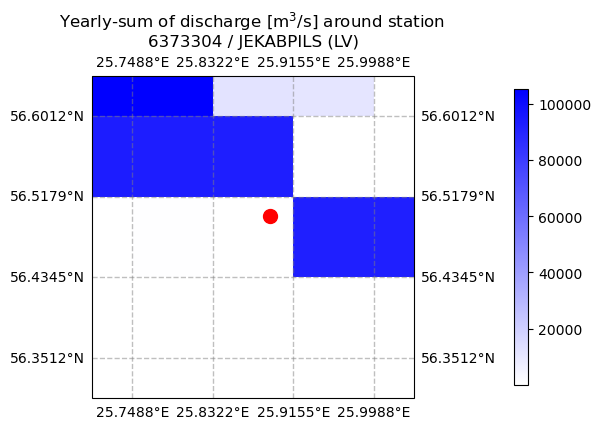

--------------------------------------------------------------------------------------------------------
6421500  /  BORGHAREN (NL) :   lat & lon: 50.87 & 5.72
6421500  /  BORGHAREN (NL) :   lat index & lon index: 243 & 196
6421500  /  BORGHAREN (NL) :   lat index fit & lon index fit: 243 & 196
6421500  /  BORGHAREN (NL) :   lat index fit & lon index fit: 50.87 & 5.72


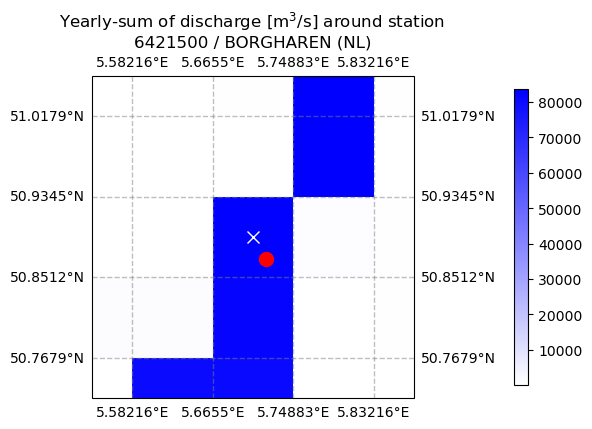

--------------------------------------------------------------------------------------------------------
6444600  /  CSENGER (HU) :   lat & lon: 47.8322 & 22.703
6444600  /  CSENGER (HU) :   lat index & lon index: 280 & 400
6444600  /  CSENGER (HU) :   lat index fit & lon index fit: 280 & 400
6444600  /  CSENGER (HU) :   lat index fit & lon index fit: 47.8322 & 22.703


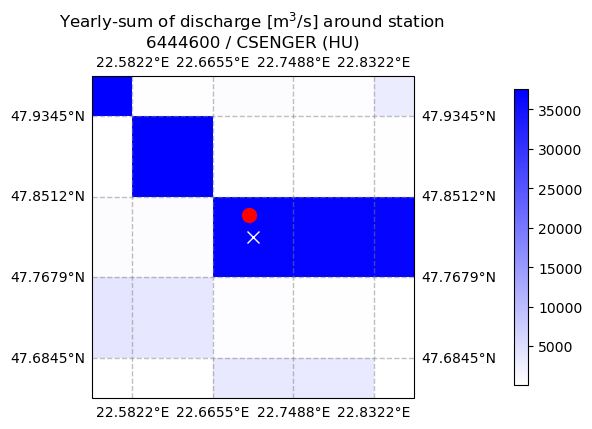

--------------------------------------------------------------------------------------------------------
6446210  /  BARCS (HU) :   lat & lon: 45.9511 & 17.4416
6446210  /  BARCS (HU) :   lat index & lon index: 302 & 337
6446210  /  BARCS (HU) :   lat index fit & lon index fit: 302 & 337
6446210  /  BARCS (HU) :   lat index fit & lon index fit: 45.9511 & 17.4416


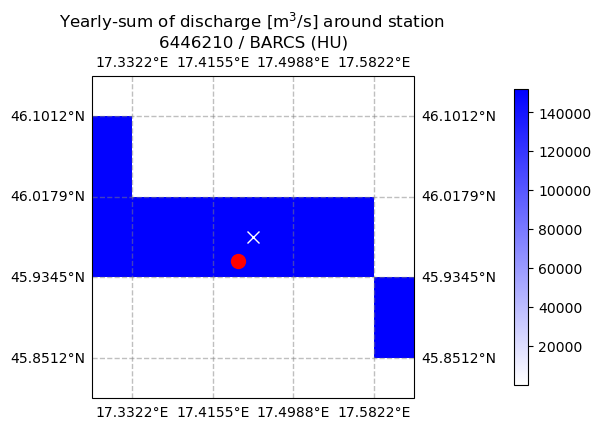

--------------------------------------------------------------------------------------------------------
6458460  /  SANDOMIERZ (PL) :   lat & lon: 50.6725 & 21.74611
6458460  /  SANDOMIERZ (PL) :   lat index & lon index: 246 & 388
6458460  /  SANDOMIERZ (PL) :   lat index fit & lon index fit: 246 & 388
6458460  /  SANDOMIERZ (PL) :   lat index fit & lon index fit: 50.6725 & 21.7461


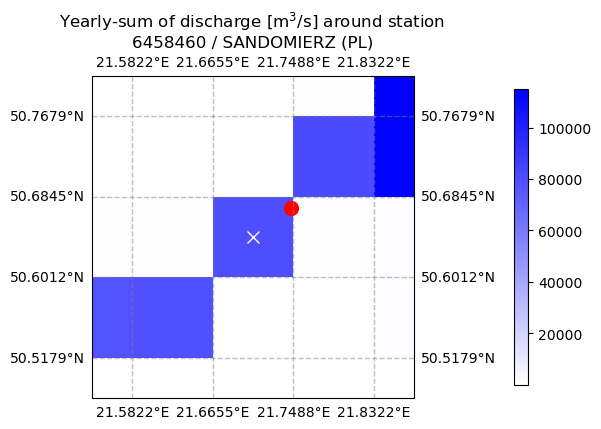

--------------------------------------------------------------------------------------------------------
6547500  /  LUBICEVSKY MOST (RS) :   lat & lon: 44.58 & 21.12
6547500  /  LUBICEVSKY MOST (RS) :   lat index & lon index: 319 & 381
6547500  /  LUBICEVSKY MOST (RS) :   lat index fit & lon index fit: 319 & 381
6547500  /  LUBICEVSKY MOST (RS) :   lat index fit & lon index fit: 44.58 & 21.12


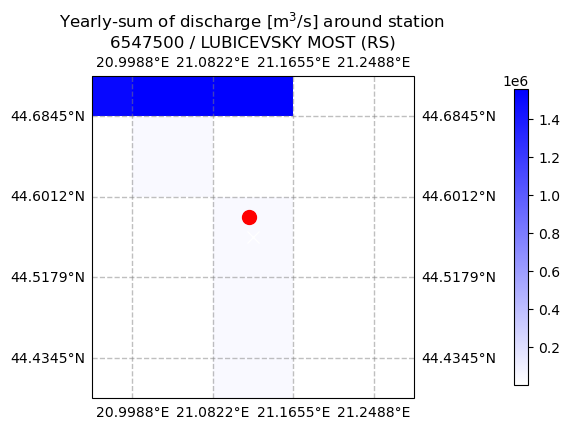

--------------------------------------------------------------------------------------------------------
6606655  /  KINGSTON (NATURALISED DISCHARGE) (GB) :   lat & lon: 51.41544 & -0.30771
6606655  /  KINGSTON (NATURALISED DISCHARGE) (GB) :   lat index & lon index: 237 & 124
6606655  /  KINGSTON (NATURALISED DISCHARGE) (GB) :   lat index fit & lon index fit: 237 & 124
6606655  /  KINGSTON (NATURALISED DISCHARGE) (GB) :   lat index fit & lon index fit: 51.4154 & -0.3077


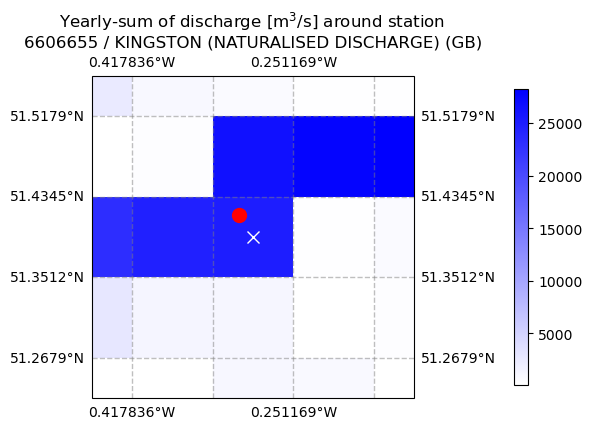

--------------------------------------------------------------------------------------------------------
6729450  /  LOSNA (NO) :   lat & lon: 61.33338 & 10.27753
6729450  /  LOSNA (NO) :   lat index & lon index: 118 & 251
6729450  /  LOSNA (NO) :   lat index fit & lon index fit: 118 & 251
6729450  /  LOSNA (NO) :   lat index fit & lon index fit: 61.3334 & 10.2775


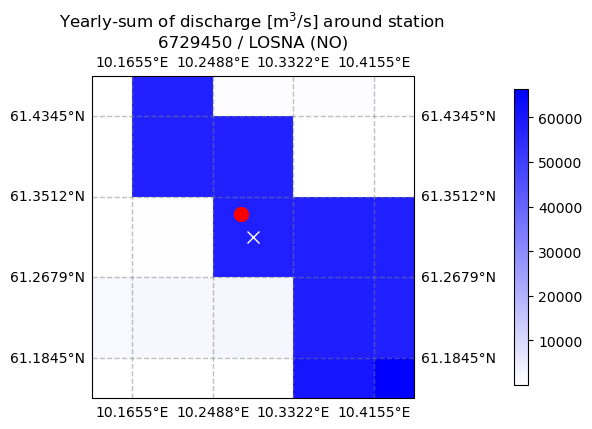

--------------------------------------------------------------------------------------------------------
6730501  /  POLMAK NYE (NO) :   lat & lon: 70.07034 & 28.01624
6730501  /  POLMAK NYE (NO) :   lat index & lon index: 13 & 464
6730501  /  POLMAK NYE (NO) :   lat index fit & lon index fit: 13 & 464
6730501  /  POLMAK NYE (NO) :   lat index fit & lon index fit: 70.0703 & 28.0162


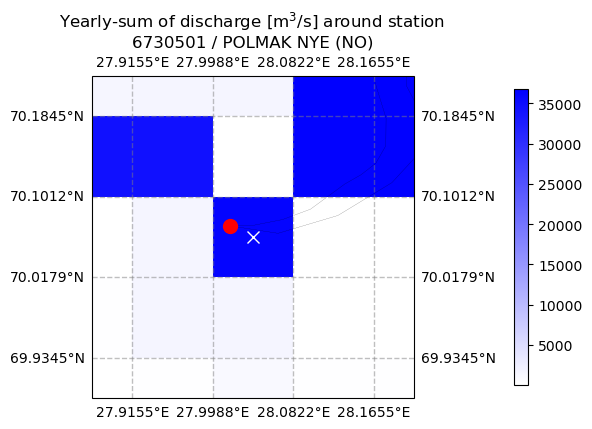

--------------------------------------------------------------------------------------------------------
6742451  /  CORNET (RO) :   lat & lon: 45.385 & 24.29944
6742451  /  CORNET (RO) :   lat index & lon index: 309 & 419
6742451  /  CORNET (RO) :   lat index fit & lon index fit: 309 & 419
6742451  /  CORNET (RO) :   lat index fit & lon index fit: 45.385 & 24.2994


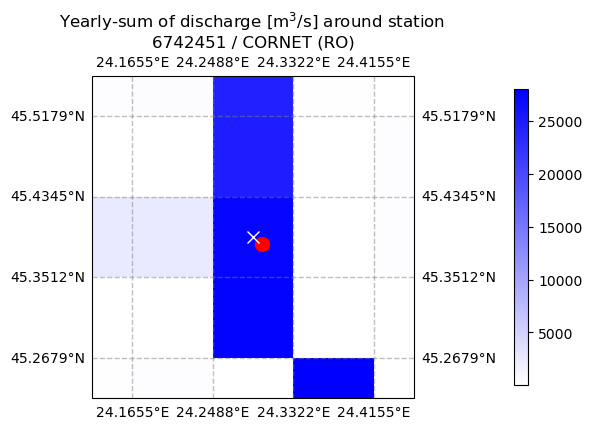

--------------------------------------------------------------------------------------------------------
6742700  /  LUNGOCI (RO) :   lat & lon: 45.55586 & 27.51222
6742700  /  LUNGOCI (RO) :   lat index & lon index: 307 & 458
6742700  /  LUNGOCI (RO) :   lat index fit & lon index fit: 307 & 458
6742700  /  LUNGOCI (RO) :   lat index fit & lon index fit: 45.5559 & 27.5122


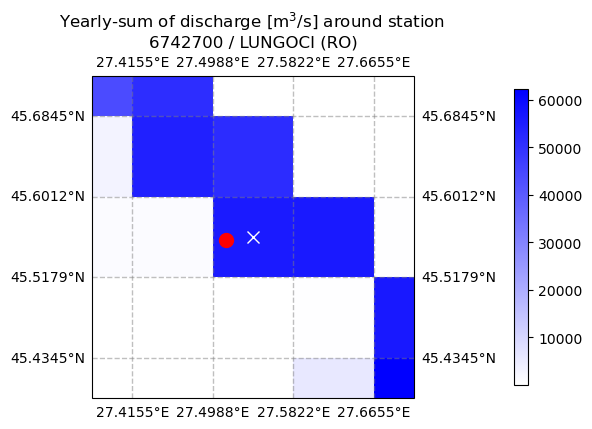

--------------------------------------------------------------------------------------------------------
6781800  /  TIGHINA (BENDERY) (MD) :   lat & lon: 46.83056 & 29.47111
6781800  /  TIGHINA (BENDERY) (MD) :   lat index & lon index: 292 & 481
6781800  /  TIGHINA (BENDERY) (MD) :   lat index fit & lon index fit: 291 & 481
6781800  /  TIGHINA (BENDERY) (MD) :   lat index fit & lon index fit: 46.9139 & 29.4711


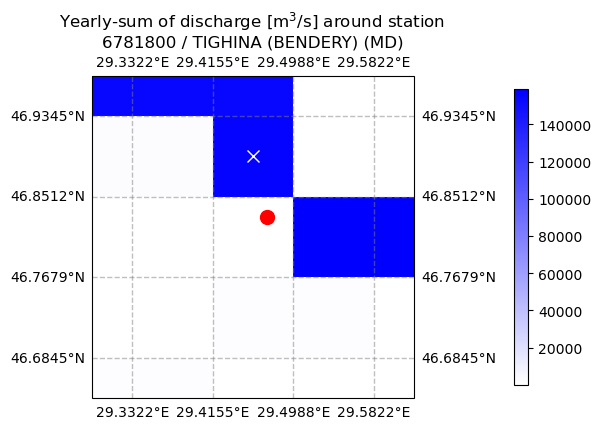

--------------------------------------------------------------------------------------------------------
6854250  /  LEPPAVESI, LUUSUA (FI) :   lat & lon: 62.245 & 25.8879
6854250  /  LEPPAVESI, LUUSUA (FI) :   lat index & lon index: 107 & 438
6854250  /  LEPPAVESI, LUUSUA (FI) :   lat index fit & lon index fit: 107 & 438
6854250  /  LEPPAVESI, LUUSUA (FI) :   lat index fit & lon index fit: 62.245 & 25.8879


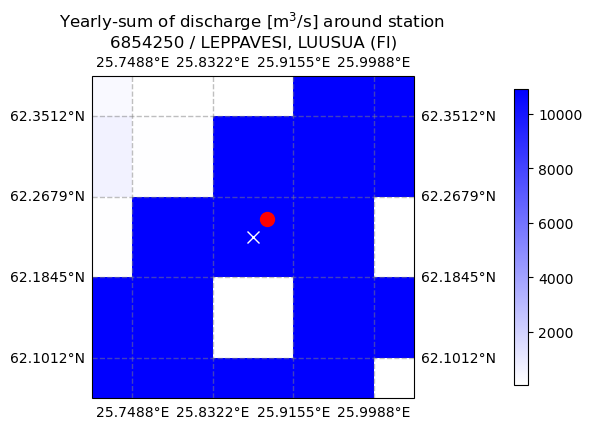

--------------------------------------------------------------------------------------------------------
6935051  /  BASEL, RHEINHALLE (CH) :   lat & lon: 47.5594 & 7.6167
6935051  /  BASEL, RHEINHALLE (CH) :   lat index & lon index: 283 & 219
6935051  /  BASEL, RHEINHALLE (CH) :   lat index fit & lon index fit: 283 & 219
6935051  /  BASEL, RHEINHALLE (CH) :   lat index fit & lon index fit: 47.5594 & 7.6167


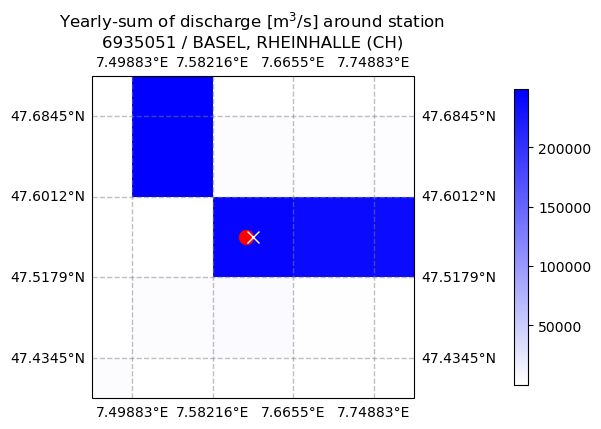

In [32]:
# Maximale und minimale Werte für z im Gesamten Zeitraum des einen Jahres herausfinden für die höchste Modifikation mit 100% 
z_min = {}
z_max = {}
for ID in list_of_station_IDs:
    z_id = np.squeeze(yearly_sum_discharge [ 0 , lat_station_index_min [ID] : lat_station_index_max [ID] + 1  , lon_station_index_min [ID] : lon_station_index_max [ID] +1 ])
    z_min [ID] = np.min(z_id)
    z_max [ID] = np.max(z_id)


# Discharge maps in Cartopy
for ID in list_of_station_IDs[10:]:
    print('--------------------------------------------------------------------------------------------------------')
    print(str(ID) , ' / ' , Dict_stationname[ID], ':  ', 'lat & lon:', np.round(lat_station[ID],5) ,  '&' , np.round(lon_station[ID],5))
    print(str(ID) , ' / ' , Dict_stationname[ID], ':  ', 'lat index & lon index:', lat_station_index[ID] , '&' , lon_station_index [ID])
    print(str(ID) , ' / ' , Dict_stationname[ID], ':  ', 'lat index fit & lon index fit:', lat_station_index_fit[ID] , '&' , lon_station_index_fit [ID])
    print(str(ID) , ' / ' , Dict_stationname[ID], ':  ', 'lat index fit & lon index fit:',lat_gauged_station[ID]  , '&' , lon_gauged_station[ID] )
    z = np.squeeze(yearly_sum_discharge[0,:,:])
    choosen_projection = ccrs.PlateCarree()   
    ax = plt.axes(projection = choosen_projection) 
    ax.set_extent([A_lon [ID], B_lon [ID], A_lat [ID], B_lat [ID]], crs = choosen_projection)
    z_color = ax.pcolormesh(x, y, z , cmap = new_color , vmin = z_min[ID], vmax = z_max[ID])
    color_bar = plt.colorbar(z_color, ax=ax, orientation='vertical', pad = 0.2 , shrink = 0.8)
    ax.coastlines(linewidth=0.1, linestyle='-')
    # Punkt für Station hinzufügen
    ax.plot(lon_station [ID], lat_station [ID], 'ro', markersize=10, transform=ccrs.PlateCarree())
    # Punkt für erwählte CWatM Zelle hinzufügen
    ax.plot(longitudes[lon_station_index_fit [ID] ], latitudes[lat_station_index_fit [ID] ], 'wx', markersize=8, transform=ccrs.PlateCarree())
    plt.title('Yearly-sum of discharge [m$^3$/s] around station \n' + str(ID) + ' / ' + Dict_stationname[ID] ) 
    xlocs = np.arange(A_lon [ID] - 0.5 * step_lon , B_lon [ID], step_lon)
    ylocs = np.arange(A_lat [ID] - 0.5 * step_lat,  B_lat [ID], step_lat)
    ax.gridlines(xlocs=xlocs, ylocs=ylocs, draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    #plt.savefig(file_save_graph_automatically + '/' + Dict_stationname[ID] + '_BestRaster' + '.jpg')
    plt.show()
    plt.close()

    
    


In [34]:
lat_gauged = xr.DataArray.from_dict(lat_gauged_station)
lon_gauged = xr.DataArray.from_dict(lon_gauged_station)

ValueError: cannot convert dict without the key 'data''

In [38]:
lat_gauged_station

<function dict.values>

In [36]:
lat_gauged_station
lat_dict = {
    'data' : 

{6113050: 39.461,
 6116200: 37.803,
 6123400: 47.0488,
 6139770: 47.0049,
 6142150: 48.6021,
 6212410: 41.5151,
 6213750: 40.0863,
 6217140: 37.9842,
 6217300: 37.5581,
 6226400: 41.6586,
 6232911: 67.2074,
 6233510: 64.2233,
 6243050: 47.5233,
 6335240: 49.7165,
 6337200: 52.964,
 6340160: 52.5466,
 6348200: 44.9485,
 6357500: 52.1536,
 6373304: 56.4976,
 6421500: 50.87,
 6444600: 47.8322,
 6446210: 45.9511,
 6458460: 50.6725,
 6547500: 44.58,
 6606655: 51.4154,
 6729450: 61.3334,
 6730501: 70.0703,
 6742451: 45.385,
 6742700: 45.5559,
 6781800: 46.9139,
 6854250: 62.245,
 6935051: 47.5594}

# Finale Werte für die Stationen ausgeben lassen

In [17]:
# Finale Werte für lat_station_index_fit und lon_station_index_fit ausgeben
for ID in list_of_station_IDs:
    print(str(ID) , ' / ' , Dict_stationname[ID], ':  ', 'lat & lon:', np.round(lat_station[ID],5) ,  '&' , np.round(lon_station[ID],5))
    print(str(ID) , ' / ' , Dict_stationname[ID], ':  ', 'lat index & lon index:', lat_station_index[ID] , '&' , lon_station_index [ID])
    print(str(ID) , ' / ' , Dict_stationname[ID], ':  ', 'lat index fit & lon index fit:', lat_station_index_fit[ID] , '&' , lon_station_index_fit [ID])
    print('----------------------------------------------------------')
    
    

6113050  /  ALMOUROL (PT) :   lat & lon: 39.461 & -8.375
6113050  /  ALMOUROL (PT) :   lat index & lon index: 380 & 27
6113050  /  ALMOUROL (PT) :   lat index fit & lon index fit: 380 & 27
----------------------------------------------------------
6116200  /  PULO DO LOBO (PT) :   lat & lon: 37.803 & -7.633
6116200  /  PULO DO LOBO (PT) :   lat index & lon index: 400 & 36
6116200  /  PULO DO LOBO (PT) :   lat index fit & lon index fit: 400 & 36
----------------------------------------------------------
6123400  /  NOUATRE (FR) :   lat & lon: 47.0488 & 0.54438
6123400  /  NOUATRE (FR) :   lat index & lon index: 289 & 134
6123400  /  NOUATRE (FR) :   lat index fit & lon index fit: 289 & 134
----------------------------------------------------------
6139770  /  NEUBLANS-ABERGEMENT (FR) :   lat & lon: 46.9216 & 5.35014
6139770  /  NEUBLANS-ABERGEMENT (FR) :   lat index & lon index: 291 & 192
6139770  /  NEUBLANS-ABERGEMENT (FR) :   lat index fit & lon index fit: 290 & 192
-----------------